In [1]:
#Activation of the libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv
import time

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.00396437 (max: 1e-06)
	Norm deltaX: 0.0115045, Norm R: 0.875302
	deltaX: -0.00221444 -0.0112893 
	deltaR: -0.662171 -0.572435 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 1.35282e-05 (max: 1e-06)
	Norm deltaX: 0.000688225, Norm R: 0.0529092
	deltaX: -0.00010739 -0.000679795 
	deltaR: -0.0411105 -0.0333063 
CTestEnergyIncr::test() - iteration: 3 current EnergyIncr: 4.58866e-08 (max: 1e-06)
	Norm deltaX: 3.95357e-05, Norm R: 0.00304669
	deltaX: -6.76235e-06 -3.89531e-05 
	deltaR: -0.00234128 -0.00194954 

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.00105749 (max: 1e-06)
	Norm deltaX: 0.00386943, Norm R: 0.572577
	deltaX: -0.00269565 -0.00277596 
	deltaR: -0.258426 -0.510941 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 3.7452e-06 (max: 1e-06)
	Norm deltaX: 0.000284191, Norm R: 0.0413228
	deltaX: -4.14479e-05 -0.000281152 
	deltaR: -0.0353296 -0.0214334 
CTestEnergyIncr::test() - ite

[[ 0.00000000e+00  0.00000000e+00]
 [ 9.81023542e-03  1.97022429e+01]
 [ 1.43255417e-02  2.83418950e+01]
 [ 1.32577020e-02  3.42165537e+01]
 [ 6.63135996e-03  4.62321134e+01]
 [-4.96025055e-03  7.17383074e+01]
 [-1.99765864e-02  1.13179666e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1.67618403e+02]
 [-3.65380381e-02  1

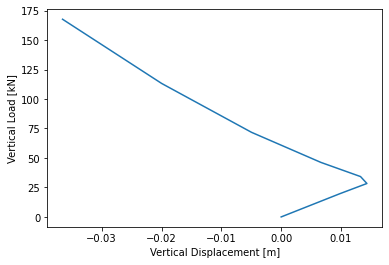

Running Time:  0.9523522853851318  seconds


In [2]:
# Define the model
ops.wipe()
start = time.time()
### model('basic', '-ndm', ndm, '-ndf', ndf=ndm*(ndm+1)/2)
ops.model('basic', '-ndm', 2, '-ndf', 2)


ArcLengthAlpha = 0.44 #Initial value of alpha (arc length parameter)
ArcLengthLambda = 0.16  #Initial value of lambda (arc length parameter)
spring_stiffness = 30.026


#Geometric and material properties
E1 = 4000000  # Modulus of elasticity in kN/m^2
A1 = 0.01  # Area of the section in m^2
E2 = 2000000  # Modulus of elasticity in kN/m^2
A2 = 0.01 # Area of the section in m^2

# Load parameters
Px = 0
Py = 30 #kN

#Coordinates of the nodes
Lhalf = 11.4
L = 2*Lhalf
### node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
ops.node(1, 0.0, 0.0)
ops.node(2, Lhalf, 1.0) 
ops.node(3, Lhalf, 1.0)
ops.node(4, L, 0.0)


# Define boundary conditions (first and third nodes are free restrained)
### fix(nodeTag, *constrValues)
ops.fix(1, 1, 1)
ops.fix(3, 1, 1)
ops.fix(4, 1, 1)

# Define material
### uniaxialMaterial(matType, matTag, *matArgs)
ops.uniaxialMaterial('Elastic', 1, E1)
ops.uniaxialMaterial('Elastic', 2, E2)

# Spring stiffness in kN/m
 
ops.uniaxialMaterial('Elastic', 3, spring_stiffness)

# Define elements using corotTruss element (accounts for geometric nonlinearity)
### element(eleType, eleTag, *eleNodes, *eleArgs)
ops.element('corotTruss', 1, 1, 2, A1, 1)
ops.element('corotTruss', 2, 2, 4, A2, 2)
ops.element('zeroLength', 3, 3, 2, '-mat', 3, '-dir', 2)

# Define load at the middle node
### timeSeries(tsType, tsTag, *tsArgs)
ops.timeSeries('Linear', 1)
### pattern(patternType, patternTag, *patternArgs)
ops.pattern('Plain', 1, 1)

#Load
###load(nodeTag, *loadValues)
ops.load(2, 0, -Py)

# create SOE - System Of Equation
### system(systemType, *systemArgs)
ops.system('ProfileSPD')

# create DOF number
### numberer(numbererType, *numbererArgs)
ops.numberer('RCM')

# create constraint handler
### constraints(constraintType, *constraintArgs)
ops.constraints('Plain')

# create integrator
Nsteps=50 #Number of increments

ops.integrator('ArcLength', ArcLengthAlpha, ArcLengthLambda) 

# create algorithm
### algorithm(algoType, *algoArgs)
ops.algorithm('ModifiedNewton', '-initial') #MODIFIED NEWTON-RAPHSON!

# create test
### test(testType, *testArgs)
ops.test('EnergyIncr', 1.0e-6, 30, 4)

# create analysis object
### analysis(analysisType)
ops.analysis("Static")

#PERFORM ANALYSIS
data = np.zeros((Nsteps+1,2)) 
for j in range(Nsteps):
    ### analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.analyze(1) 
    data[j+1,0] = ops.nodeDisp(2,1)    #abs(ops.nodeDisp(2,2)) 
    data[j+1,1] = ops.getLoadFactor(1)*Py 
print(data)
results = pd.DataFrame(data, columns=['Displacement','Force'])
results.to_excel('Results - Arclength Method - RIKS AND WAMPNER.xlsx')

plt.plot(data[:,0], data[:,1])
plt.xlabel('Vertical Displacement [m]')
#plt.ylim(-30, 100)
plt.ylabel('Vertical Load [kN]')
plt.show()

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')